In [154]:
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
import gensim

from scipy.spatial.distance import cosine as cos
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

#### Importer deux modèles word2vec, le premier pour 1802-1859, le deuxième pour 1860-1888


In [2]:
model_early = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('../data/models/word2vec_early_270422/keyedvectors.txt')
model_late = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('../data/models/word2vec_late_270422/keyedvectors.txt')

#### Code pour l'alignement des vecteurs provenant de HistWords, légerement modifié

Je comprends la base du processus, mais les opérations mathématiques m'échappent toujours. Le couer de la manipulation se trouve en fait dans les lignes 25-33 de la cellule suivante. Après la normalisation des vecteurs des deux modèles, la ligne 28 effectue une décomposition en valeurs singulières et ensuite il y a des multipications de quelque sorte... En gros, je ne sais pas vérifier les résultats).

In [3]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)
    
    # re-filling the normed vectors
    in_base_embed.fill_norms(force=True)
    in_other_embed.fill_norms(force=True)

    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.get_normed_vectors()
    other_vecs = in_other_embed.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    in_other_copy = copy.deepcopy(in_other_embed)
    in_other_copy.vectors = (in_other_embed.vectors).dot(ortho)    
    
    return in_other_copy


def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.index_to_key)
    vocab_m2 = set(m2.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.get_vecattr(w, "count") + m2.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.key_to_index[w] for w in common_vocab]
        old_arr = m.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.key_to_index = new_key_to_index
        m.index_to_key = new_index_to_key
        
        print(len(m.key_to_index), len(m.vectors))
        
    return (m1,m2)

In [7]:
model_late_aligned = smart_procrustes_align_gensim(model_early, model_late)

In [8]:
model_late_aligned

In [144]:
ents_df = pd.read_excel('../pipeline/ner/ruler_patterns.xlsx').convert_dtypes()
#ents_df = ents_df[ents_df['key'].isin([word for word in ents_df.key if model_late_aligned.has_index_for(word)])]
#ents = ents_df.key
#ents_normalized = ents_df.wordform

Je choisis une échantillon des entités dont les vecteurs nous allons comparer pour ces exemples:

In [170]:
examples = np.random.choice([word for word in ents_normalized
                             if model_early.has_index_for(word) and model_late_aligned.has_index_for(word)],
                             size=10, replace=False)
print(examples)

['hagelschlag' 'windstille' 'schneegestöber' 'gewittersturm' 'frost'
 'ostwind' 'hagel' 'nordwind' 'überschwemmung' 'schönes_wetter']


Je teste deux méthodes de réduction dimensionnelle : PCA et t-SNE

### PCA

In [171]:
def pca_example(examples):
    
    df = pd.DataFrame(index=list(examples)+[word+'_2' for word in examples],
                  data=[model_early[word] for word in examples] + [model_late_aligned[word] for word in examples])
    
    pca = PCA()
    pca.fit(df)
    pca_data = pca.transform(df)
    
    per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
    labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
    
    pca_df = pd.DataFrame(data=pca_data, index=df.index, columns=labels)

    plt.figure(figsize=(10,10))
    
    plt.scatter(pca_df.PC1, pca_df.PC2)
    plt.xlabel('PC1 - {0}%'.format(round(per_var[0], 2)))
    plt.ylabel('PC2 - {0}%'.format(round(per_var[1], 2)))
     
    for sample in pca_df.index:
        if '2' in sample:
            plt.annotate(sample[:-2], (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]), size=16, color='red')
        else:
            plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]), size=16)
            
    plt.show()

**Ce premier graphique PCA montre les vecteurs des toutes les entités dans les deux périodes (noir pour 1802-1859, rouge pour 1860-1888). Le positionnement montre que ce qui s'est passé lors de la procédure d'alignement semble avoir du sens, car la plupart des entités sont assez proches de leurs équivalents de l'autre période. Elles ne sont pas regroupées en deux clusters distincts, l'un pour la période précoce et l'autre pour la période tardive.**

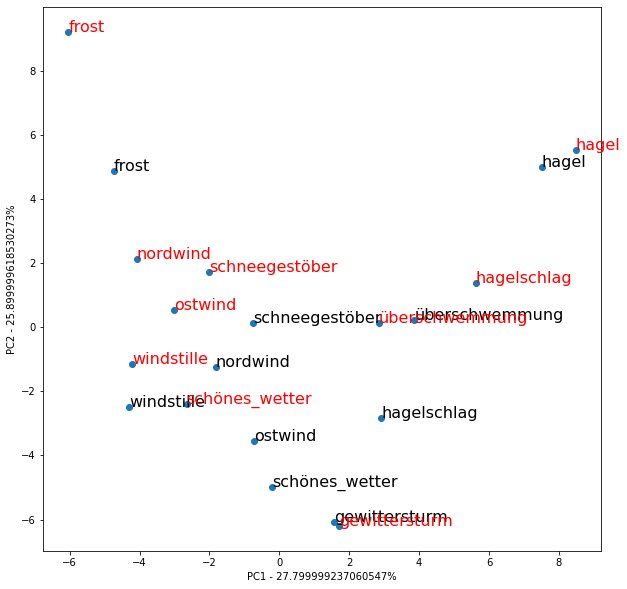

In [172]:
pca_example(examples)

In [66]:
def pca_example_2(word, topn):
    
    data_points = np.vstack((model_early.get_vector(word),
                                    np.array([model_early.get_vector(key) for (key, sim) in model_early.most_similar(word, topn=topn)]),
                                    model_late_aligned.get_vector(word)))
        
    df = pd.DataFrame(index=[word+'_1']+[key for (key, sim) in model_early.most_similar(word, topn=topn)]+[word+'_2'],
                      data=data_points)
    
    pca = PCA()
    pca.fit(df)
    pca_data = pca.transform(df)
    
    per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
    labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
    
    pca_df = pd.DataFrame(data=pca_data, index=df.index, columns=labels)

    plt.figure(figsize=(10,10))
    
    plt.scatter(pca_df.PC1, pca_df.PC2)
    plt.xlabel('PC1 - {0}%'.format(round(per_var[0], 2)))
    plt.ylabel('PC2 - {0}%'.format(round(per_var[1], 2)))
     
    for sample in pca_df.index:
        if '_2' in sample:
            plt.annotate(sample[:-2], (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]), size=16, color='red')
        elif '_1' in sample:
            plt.annotate(sample[:-2], (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]), size=16, color='blue')
        else:
            plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]), size=16)
            
    plt.show()

**Le deuxième graphique PCA prend une seule entité en entrée (ici "climat", en bleu), trouve un nombre d'entités (ici 10) les plus similaires à lui dans la période 1802-1859, et les visualise ensemble avec le vecteur du mot d'entrée dans l'autre période (en rouge). Cela essaie de reproduire les graphiques du papier ou les vecteurs d'une période sont utilisées comme le contexte pour montrer le glissement sémantique.**

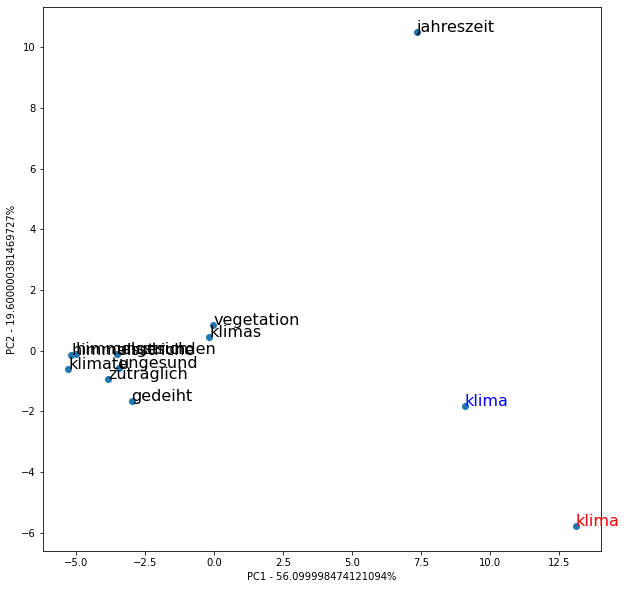

In [178]:
pca_example_2('klima', 10)

### t-SNE

In [174]:
def tsne_example(examples):

    df = pd.DataFrame(index=list(examples)+[word+'_2' for word in examples],
                  data=[model_early[word] for word in examples] + [model_late_aligned[word] for word in examples])
    
    tsne = TSNE(2)
    tsne_result = tsne.fit_transform(df)
    tsne_result_df = pd.DataFrame(
        {'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': df.index}
    )
    
    tsne_result_df['period'] = tsne_result_df['label'].apply(lambda x: 2 if '2' in x else 1)
    
    plt.figure(figsize=(12,12))
    sns.scatterplot(data=tsne_result_df, x='tsne_1', y='tsne_2', hue='period')
    
    for ix, row in tsne_result_df.iterrows():
        if '_2' in row['label']:
            plt.annotate(row['label'][:-2], (row['tsne_1']+0.2, row['tsne_2']+0.2), size=16, color='red')
        elif '_1' in row['label']:
            plt.annotate(row['label'][:-1], (row['tsne_1']+0.2, row['tsne_2']+0.2), size=16, color='blue')
        else:
            plt.annotate(row['label'], (row['tsne_1']+0.2, row['tsne_2']+0.2), size=16)
    
    plt.legend()
    plt.show()

**Ici l'équivalent du premier graphique qui visualise toutes les entités de l'échantillon, mais cette fois-ci avec t-SNE.**

c:\users\krister\climdist\v_env\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\krister\climdist\v_env\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


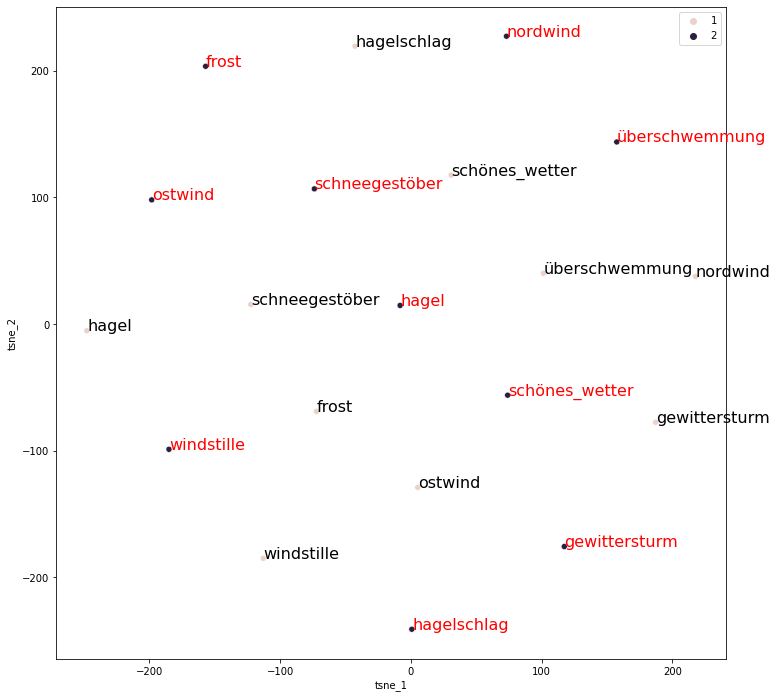

In [175]:
tsne_example(examples)

In [176]:
def tsne_example2(word, topn):

    data_points = np.vstack((model_early.get_vector(word),
                                    np.array([model_early.get_vector(key) for (key, sim) in model_early.most_similar(word, topn=topn)]),
                                    model_late_aligned.get_vector(word)))
        
    df = pd.DataFrame(index=[word+'_1']+[key for (key, sim) in model_early.most_similar(word, topn=topn)]+[word+'_2'],
                      data=data_points)
    
    tsne = TSNE(2)
    tsne_result = tsne.fit_transform(df)
    tsne_result_df = pd.DataFrame(
        {'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': df.index}
    )
    
    tsne_result_df['period'] = tsne_result_df['label'].apply(lambda x: 2 if '2' in x else 1)
    
    plt.figure(figsize=(12,12))
    sns.scatterplot(data=tsne_result_df, x='tsne_1', y='tsne_2', hue='period')
    
    for ix, row in tsne_result_df.iterrows():
        if '_2' in row['label']:
            plt.annotate(row['label'], (row['tsne_1']+0.2, row['tsne_2']+0.2), size=16, color='red')
        elif '_1' in row['label']:
            plt.annotate(row['label'], (row['tsne_1']+0.2, row['tsne_2']+0.2), size=16, color='blue')
        else:
            plt.annotate(row['label'], (row['tsne_1']+0.2, row['tsne_2']+0.2), size=16)
    
    plt.legend()
    plt.show()

**L'équivalent du deuxième graphique PCA qui analyse le contexte et changement d'une seule entité**

c:\users\krister\climdist\v_env\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\krister\climdist\v_env\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


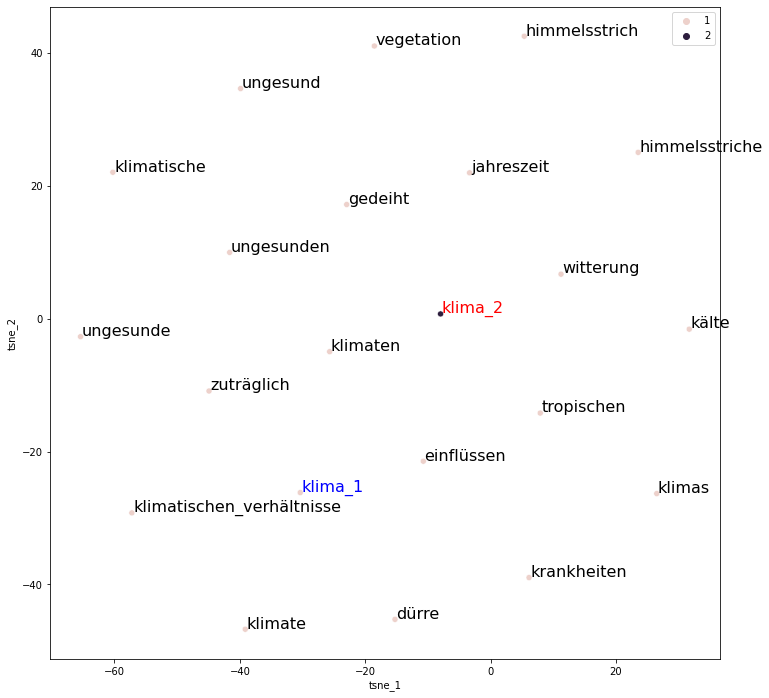

In [177]:
tsne_example2('klima', 20)

**Conclusion : je ne suis pas complètement sûr si l'alignement est bien marché. Les glissements que j'ai visualisé ne sont pas assez significants que j'en pourrais tirer des conclusions, au moins pour les mots que j'ai testés. J'ai aussi calculé les mots dont le glissement a été le plus grand entre les deux périodes selon leur similarité cosinus, mais même les mots dont la similarité a été la plus petite ont donné des graphiques similaires. Je pense qu'il peut y avoir trois explications:**

- L'alignement ne fonctionne bien
- In n'y avait pas des glissements sémantiques importants pendant le siécle (cependant improbable, parce que les auteurs du papier ont observé des changements notables aussi au cours d'une demi-siècle)
- Mon corpus est trop petit, trop déséquilibré (la deuxième moitié contient plus de matériel et son modèle devrait être plus précis) ou trop bruité.